In [2]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(2468)
random_state = 12

In [3]:
# Model Hyperparameters

dataset_path = './data'

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps or torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

batch_size = 64
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings = 512
embedding_dim = 64
output_dim = 3
commitment_beta = 0.25

lr = 2e-4

epochs = 10
print_steps = 10

Using device: mps


/var/folders/w9/d3h7vx393175sc9kvpd02znh0000gn/T/ipykernel_67258/2223527363.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps or torch.backends.mps.is_available() else 'cpu'


## Step 1. Load(or download) Dataset

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0)),
    ]
)

train_dataset = datasets.CIFAR10(dataset_path, train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(dataset_path, train=False, download=True, transform=transform)

data_variance = np.var(train_dataset.data / 255.0)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:15<00:00, 10.8MB/s] 


## Step 2. Define our model: Variational AutoEncoder (VQ_VAE)

In [17]:
class VectorQuantize(nn.Module):
    def __init__(self, num_embeds: int, embed_dim: int, commitment_cost: float = 0.25, decay: float = 0.999, epsilon: float = 1e-5) -> None:
        super(VectorQuantize, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        self.num_embeds = num_embeds
        self.embed_dim = embed_dim
        
        init_bound = 1 / num_embeds
        self.embed = nn.Embedding(self.num_embeds, self.embed_dim)
        self.embed.weight.data.uniform_(-1 / self.num_embeds, 1 / self.num_embeds)
        
        # self.register_buffer('embedding', self.embed.weight)
        # self.register_buffer('ema_count', torch.zeros(num_embeds))
        # self.register_buffer('ema_w', self.embed.clone())
        
    def forward(self, z_e: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        z_e = z_e.permute(0, 2, 3, 1).contiguous() # ( b, h', w', embed_dim )
        z_e_shape = z_e.shape
        z_e_flatten = z_e.view(-1, self.embed_dim) # ( b * h' * w', embed_dim )
        
        # L2 distances
        distances = (z_e_flatten ** 2).sum(dim=1, keepdim=True) + (self.embed.weight ** 2).sum(dim=1) - 2 * torch.matmul(z_e_flatten, self.embed.weight.T)
        # ( b * h' * w', num_embeds )
        
        # Find the near emebedding vector index
        encoding_indices = torch.argmin(distances, dim=1)
        # ( b * h' * w', )
        
        encoding = F.one_hot(encoding_indices, num_classes=self.num_embeds).to(torch.float32)
        # ( b * h' * w', num_embeds )
        
        # One hot encoding and codebook vectors multiplication and reshape
        z_q = torch.matmul(encoding, self.embed.weight).view(z_e_shape)
        # ( b, h', w', embed_dim )
        
        e_latent_loss = F.mse_loss(z_q.detach(), z_e)
        q_latent_loss = F.mse_loss(z_q, z_e.detach())
        loss = e_latent_loss + self.commitment_cost * q_latent_loss
        
        z_q = z_e + (z_q - z_e).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous() # ( b, embed_dim, h', w' )
        
        # preplexity
        avg_probs = torch.mean(encoding, dim=0)
        preplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + self.epsilon)))
        
        return loss, z_q, preplexity, encoding

In [22]:
class Residual(nn.Module):
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_hiddens: int) -> None:
        super(Residual, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)

In [23]:
class ResidualStack(nn.Module):
    def __init__(self, in_channels: int, num_hiddens: int, num_residual_layers: int = 2, num_residual_hiddens: int = 32) -> None:
        super(ResidualStack, self).__init__()
        
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels=in_channels, num_hiddens=num_hiddens, num_residual_hiddens=num_residual_hiddens)
                for _ in range(self.num_residual_layers)
            ]
        )
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in range(self.num_residual_layers):
            x = self.layers[layer](x)
        return x

In [37]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens: int, num_embeds: int, embed_dim: int, in_channels: int = 3, num_residual_layers: int = 2, num_residual_hiddens: int = 32, commitment_cost: float = 0.25) -> None:
        super(VQVAE, self).__init__()
        
        # Encoder
        self.conv_enc1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1)
        self.conv_enc2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens, kernel_size=4, stride=2, padding=1)
        self.conv_enc3 = nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1)
        
        self.residual_enc = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens,
                                            num_residual_layers=num_residual_layers,
                                            num_residual_hiddens=num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embed_dim, kernel_size=1, stride=1)
        self.vq = VectorQuantize(num_embeds=num_embeds, embed_dim=embed_dim, commitment_cost=commitment_cost)
        
        # Decoder
        self.conv_dec = nn.Conv2d(in_channels=embed_dim, out_channels=num_hiddens, kernel_size=1, stride=1)
        
        self.residual_dec = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens,
                                            num_residual_layers=num_residual_layers,
                                            num_residual_hiddens=num_residual_hiddens)
        
        self.convt_dec1 = nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1)
        self.convt_dec2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv_enc1(x))
        x = F.relu(self.conv_enc2(x))
        x = self.conv_enc3(x)
        x = self.residual_enc(x)        
        return x
    
    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        z = self.conv_dec(z)
        z = self.residual_dec(z) 
        z = F.relu(self.convt_dec1(z))
        z = self.convt_dec2(z)
        return z
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z_e = self.encoder(x) # ( b, num_hiddens, h', w' )
        
        z_e = self.pre_vq_conv(z_e) # ( b, embed_dim, h', w' )
        
        loss, z_q, preplexity, _ = self.vq(z_e)
        # (, ), ( b, embed_dim, h', w' ), (, )
        
        x_recon = self.decoder(z_q)
        
        return loss, x_recon, preplexity

In [38]:
model = VQVAE(num_hiddens=hidden_dim, num_embeds=n_embeddings, embed_dim=embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    losses = []
    vq_losses = []
    recon_losses = []
    
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        vq_loss, x_recon, preplexity = model(x)
        recon_loss = F.mse_loss(x, x_recon) / data_variance
        loss = recon_loss + vq_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach().numpy())
        recon_losses.append(recon_loss.cpu().detach().numpy())
        vq_losses.append(vq_loss.cpu().detach().numpy())
        
    losses_val = []
    model.eval()
    for x, _ in val_loader:
        x = x.to(device)
        vq_loss, x_recon, perplexity = model(x)
        recon_loss = F.mse_loss(x, x_recon) / data_variance
        loss = recon_loss + vq_loss
        losses_val.append(loss.cpu().detach().numpy())
        
    print(f'Epoch: {epoch + 1}, Loss: {np.mean(losses)}, Recon Loss: {np.mean(recon_losses)}, VQ Loss: {np.mean(vq_losses)}, Val Loss: {np.mean(losses_val)}')

Epoch: 1, Loss: 6.323617935180664, Recon Loss: 0.4731106460094452, VQ Loss: 5.8505072593688965, Val Loss: 1.8705894947052002
Epoch: 2, Loss: 0.9023666977882385, Recon Loss: 0.2762661874294281, VQ Loss: 0.626100480556488, Val Loss: 0.44932323694229126
Epoch: 3, Loss: 0.3454863727092743, Recon Loss: 0.20589827001094818, VQ Loss: 0.13958808779716492, Val Loss: 0.30138343572616577
Epoch: 4, Loss: 0.2561500370502472, Recon Loss: 0.1671678125858307, VQ Loss: 0.0889822244644165, Val Loss: 0.22795775532722473
Epoch: 5, Loss: 0.2052629441022873, Recon Loss: 0.14096997678279877, VQ Loss: 0.06429295241832733, Val Loss: 0.18764673173427582
Epoch: 6, Loss: 0.17716896533966064, Recon Loss: 0.12630845606327057, VQ Loss: 0.05086050555109978, Val Loss: 0.17484495043754578
Epoch: 7, Loss: 0.15852826833724976, Recon Loss: 0.11655169725418091, VQ Loss: 0.041976578533649445, Val Loss: 0.1511080116033554
Epoch: 8, Loss: 0.14698058366775513, Recon Loss: 0.10939344763755798, VQ Loss: 0.037587132304906845, Val

## Step 3. Generate the image

### 3.1 Original image

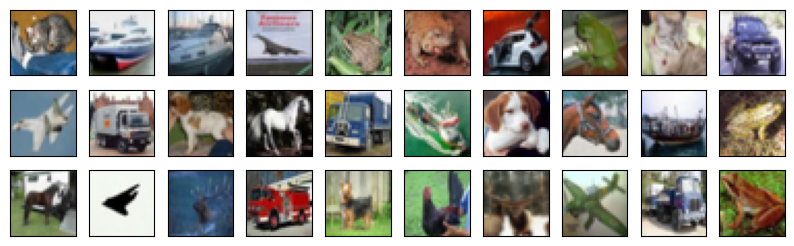

In [43]:
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(30):
    x, _ = val_dataset[i]

    im = x.view(-1, 32, 32).permute(1, 2, 0).squeeze().numpy() + 0.5

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im)

### 3.2 Reconsturct image

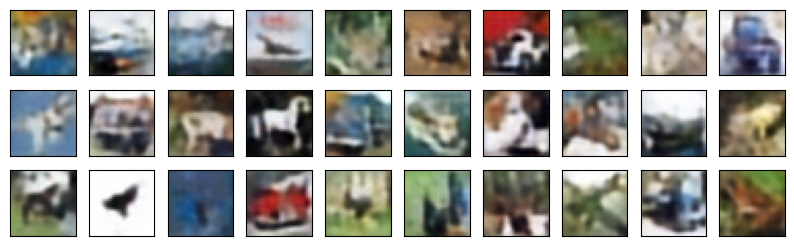

In [44]:
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(30):
    x, _ = val_dataset[i]

    x = x.unsqueeze(0).to(device)

    _, x_recon, _ = model(x)

    im = x_recon.view(-1, 32, 32).permute(1, 2, 0).detach().cpu().squeeze().numpy() + 0.5
    im = np.clip(im, 0, 1)

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im)

### 3.3 Generated samples via random codes

In [49]:
def gene_random_smaple_image(codebook, decoder, indicaes_shape):
    # Create random indices
    indices = torch.randint(0, codebook.shape[0], indicaes_shape).to(device)
    # Rearrange to (C, H, W)
    z_q = codebook[indices].permute(2, 0, 1).unsqueeze(0).contiguous()
    # Decode
    x_recon = model.decoder(z_q) # Expect shape: (1, 3, 32, 32) or similar
    
    # Process image
    im = x_recon.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # to HWC
    im = np.clip(im + 0.5, 0, 1)
    return im

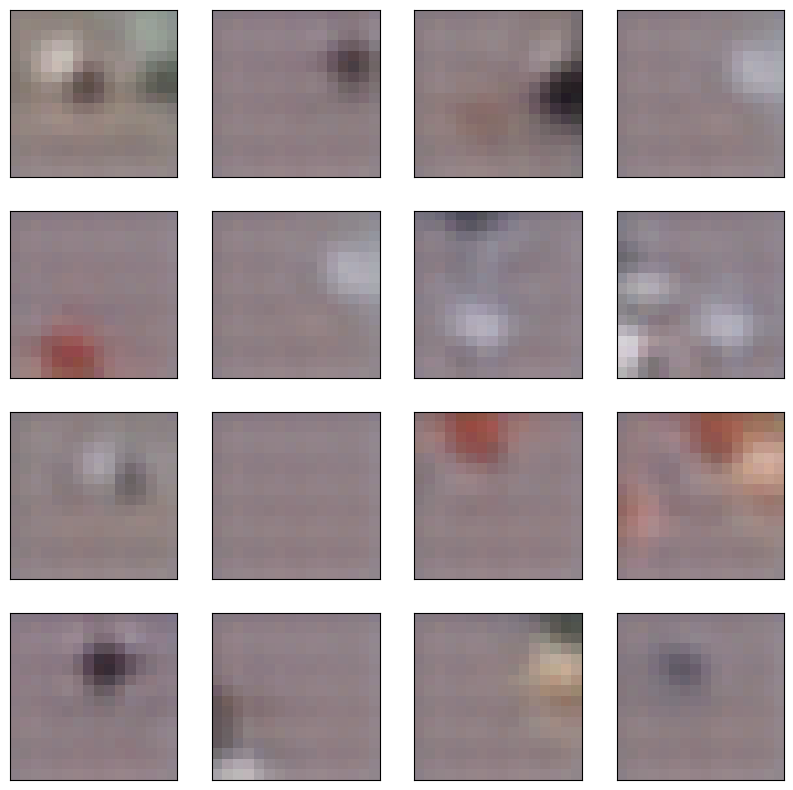

In [51]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    im = gene_random_smaple_image(model.vq.embed.weight, model.decoder, (4, 4))

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(im)
plt.show()